In [1]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3

# Data processing: Join PHQ9, GAD7 and ACE datasets together by record_id and redcap_event_name

In [2]:
data = data_load(data_keys={'phq9', 'generalized_anxiety_disorder_scale_gad7', 'ace', 'surveys', 'study_ids', 'check_in_adherence_log'})

In [3]:
outcomes = pd.merge(data['phq9'], data['generalized_anxiety_disorder_scale_gad7'],  how='outer', left_on=['record_id','redcap_event_name'], right_on = ['record_id','redcap_event_name'])

In [4]:
overall_df = pd.merge(data['ace'].drop(columns=['redcap_event_name']).dropna(), outcomes, how='left', on='record_id')

# Convert redcap_event_name to date for PHQ9, GAD7 and ACE datasets

In [5]:
# read study ids
id_df = data['study_ids'][['record_id', 'evidation_id']]
id_df.rename(columns={'evidation_id': 'user_id'}, inplace=True)

# add ids to survey
overall_df = overall_df.merge(id_df, on=['record_id'])
overall_df.user_id = overall_df.user_id.fillna(-1).astype(int)

# read check-in dates
ci_df = data['check_in_adherence_log']
cols = ['record_id'] + [col for col in ci_df.columns if col.endswith('_date')]
ci_df = ci_df[cols]

# add dates to survey
overall_df = overall_df.merge(ci_df, on=['record_id'])
overall_df['checkin_number'] = overall_df.redcap_event_name.str.split('ci_').str[1].str.split('_arm').str[0].fillna(0).astype(int)
overall_df['date'] = overall_df.apply(lambda x: x[f'checkin_{str(x.checkin_number)}_date'] if x.checkin_number > 0 else None, axis=1)
overall_df = overall_df[overall_df.columns.drop(list(overall_df.filter(regex='checkin_')))]
overall_df['date'] = pd.to_datetime(overall_df['date'])

In [6]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
overall_df.head()

,record_id,ace_1,ace_2,ace_3,ace_4,ace_5,ace_6,ace_7,ace_8,ace_9,ace_10,ace_complete,redcap_event_name,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_10,phq9_complete,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,gad_8,generalized_anxiety_disorder_scale_gad7_complete,user_id,date
0,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_1_arm_1,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,1.0,0.0,2.0,1.0,3.0,0.0,1.0,2.0,28,2021-03-18
1,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_2_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2.0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,28,2021-04-01
2,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_3_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,1.0,0.0,2.0,2.0,3.0,1.0,1.0,2.0,28,2021-04-15
3,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_4_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,28,2021-04-29
4,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_5_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,28,2021-05-13


# Add Global survey data - PROMIS quality of life

In [7]:
promis_survey = data['surveys']
promis_survey = promis_survey.loc[promis_survey['question_id'] == 121]
promis_survey['date'] = pd.to_datetime(promis_survey['date'])

In [8]:
promis_survey['question_text'].unique()

array(['In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?'],
      dtype=object)

In [9]:
promis_survey['answer_text'].unique()

array(['Never', 'Rarely', 'Sometimes', 'Often', 'Always'], dtype=object)

In [10]:
promis_survey.loc[promis_survey['user_id'] == 28]

,id,user_id,survey_id,title,event_date,from,to,created_at,updated_at,question_id,question_text,answer_text,date
222517,42274,28,11,Global survey,2021-04-27 00:00:00,2021-04-27 22:00:00,2021-04-28 01:00:00,2021-04-27 04:05:23.974126,2021-04-27 22:13:58.456141,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Sometimes,2021-04-27
222522,70479,28,11,Global survey,2021-05-25 00:00:00,2021-05-25 22:00:00,2021-05-26 01:00:00,2021-05-25 04:05:38.04252,2021-05-25 22:01:50.393004,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Sometimes,2021-05-25
222559,112393,28,11,Global survey,2021-06-22 00:00:00,2021-06-22 22:00:00,2021-06-23 01:00:00,2021-06-22 05:07:02.791691,2021-06-22 22:02:06.555992,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Sometimes,2021-06-22
222749,497891,28,11,Global survey,2021-11-09 00:00:00,2021-11-09 05:00:00,2021-11-10 05:00:00,2021-11-09 05:10:22.060597,2021-11-09 18:39:56.79676,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-11-09
222800,17445,28,11,Global survey,2021-03-02 00:00:00,2021-03-02 23:00:00,2021-03-03 02:00:00,2021-03-02 05:05:12.924307,2021-03-02 23:02:29.913693,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-03-02
222804,24712,28,11,Global survey,2021-03-30 00:00:00,2021-03-30 22:00:00,2021-03-31 01:00:00,2021-03-30 05:05:15.752291,2021-03-30 22:03:08.22026,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-03-30
222825,397784,28,11,Global survey,2021-10-12 00:00:00,2021-10-12 04:00:00,2021-10-13 04:00:00,2021-10-12 05:08:41.803388,2021-10-12 18:43:19.486764,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-10-12
222847,170973,28,11,Global survey,2021-07-20 00:00:00,2021-07-20 04:00:00,2021-07-21 04:00:00,2021-07-20 05:13:18.264439,2021-07-20 13:29:23.240445,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Often,2021-07-20
222910,310417,28,11,Global survey,2021-09-14 00:00:00,2021-09-14 04:00:00,2021-09-15 04:00:00,2021-09-14 05:07:56.145651,2021-09-14 17:57:05.426492,121,"In the past 7 days:\r\n\r\nHow often have you been bothered by emotional problems such as feeling anxious, depressed or irritable?",Always,2021-09-14


In [11]:
overall_df.head()

,record_id,ace_1,ace_2,ace_3,ace_4,ace_5,ace_6,ace_7,ace_8,ace_9,ace_10,ace_complete,redcap_event_name,phq9_1,phq9_2,phq9_3,phq9_4,phq9_5,phq9_6,phq9_7,phq9_8,phq9_9,phq9_10,phq9_complete,gad_1,gad_2,gad_3,gad_4,gad_5,gad_6,gad_7,gad_8,generalized_anxiety_disorder_scale_gad7_complete,user_id,date
0,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_1_arm_1,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,1.0,0.0,2.0,1.0,3.0,0.0,1.0,2.0,28,2021-03-18
1,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_2_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2.0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,28,2021-04-01
2,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_3_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,1.0,0.0,2.0,2.0,3.0,1.0,1.0,2.0,28,2021-04-15
3,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_4_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,28,2021-04-29
4,4,1,1,0,1.0,1,0,1,1,0,0,2,ci_5_arm_1,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,28,2021-05-13


# Process PHQ9, GAD and PROMIS data by taking the average over time for each individual

In [104]:
ace_levels = {
    (0, 1) : 0,
    (2, 10): 1
}
phq9_levels = {
    (0, 4) : 0,
    (5, 9): 1,
    (10, 14): 1,
    (15, 19): 1,
    (20, 27): 1
}
gad_levels = {
    (0, 4) : 0,
    (5, 9): 1,
    (10, 14): 1,
    (15, 21): 1
}
promis_levels = {
    "Always" : 0,
    "Often": 0,
    "Sometimes": 0,
    "Rarely": 1,
    "Never": 1
}
# phq9_levels = {
#     (0, 4) : 0,
#     (5, 9): 1,
#     (10, 14): 2,
#     (15, 19): 3,
#     (20, 27): 4
# }
# gad_levels = {
#     (0, 4) : 0,
#     (5, 9): 1,
#     (10, 14): 2,
#     (15, 21): 3
# }
# promis_levels = {
#     "Always" : 0,
#     "Often": 1,
#     "Sometimes": 2,
#     "Rarely": 3,
#     "Never": 4
# }
def map_levels(x, map_dict):
    for key in map_dict:
        if isinstance(x, str):
            if x == key:
                return map_dict[key]
        else:
            if x >= key[0] and x <= key[1]:
                return map_dict[key]

In [105]:
processed_overall_df = pd.DataFrame(columns=['user_id', 'ace_sum', 'phq9_sum', 'gad_sum', 'promis_mean'])
for uid in overall_df['user_id'].unique():
    each_df = overall_df.loc[overall_df['user_id']==uid]
    ace_lst = [f'ace_{x}' for x in range(1,11)]
    phq9_lst = [f'phq9_{x}' for x in range(1,11)]
    gad_lst = [f'gad_{x}' for x in range(1,9)]
    ace_sum = each_df[ace_lst].sum(axis=1)
    ace_sum_mean = ace_sum.apply(map_levels, map_dict=ace_levels).mean()
    phq9_sum = each_df[phq9_lst].sum(axis=1)
    phq9_sum_mean = phq9_sum.apply(map_levels, map_dict=phq9_levels).mean()
    gad_sum = each_df[gad_lst].sum(axis=1)
    gad_sum_mean = gad_sum.apply(map_levels, map_dict=gad_levels).mean()
    each_promis_df = promis_survey.loc[promis_survey['user_id']==uid]['answer_text'].apply(map_levels, map_dict=promis_levels)
    promis_mean = each_promis_df.mean()
    processed_overall_df = processed_overall_df.append({'user_id': uid, 'ace_sum': ace_sum_mean, 'promis_mean': promis_mean, 'phq9_sum': phq9_sum_mean, 'gad_sum': gad_sum_mean}, ignore_index=True)

In [106]:
processed_overall_df = processed_overall_df.dropna()

In [87]:
# processed_overall_df.to_csv('processed_causal_ace_4nodes.csv', index=False)

In [88]:
# processed_overall_df[['phq9_sum', 'gad_sum', 'promis_mean']] = processed_overall_df[['phq9_sum', 'gad_sum', 'promis_mean']] * 5

<AxesSubplot:>

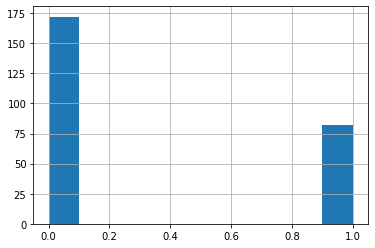

In [107]:
processed_overall_df['ace_sum'].hist()

<AxesSubplot:>

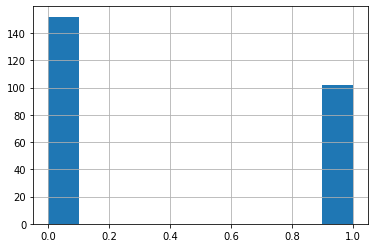

In [108]:
processed_overall_df['phq9_sum'].round().hist()

<AxesSubplot:>

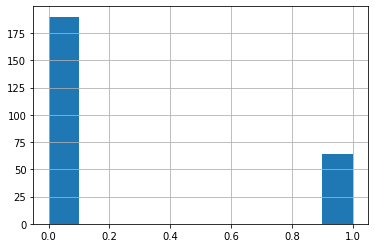

In [109]:
processed_overall_df['gad_sum'].round().hist()

<AxesSubplot:>

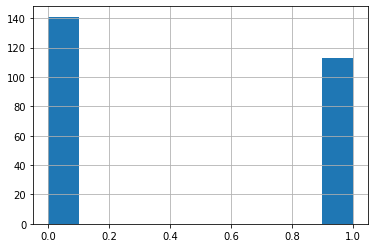

In [110]:
processed_overall_df['promis_mean'].round().hist()

In [36]:
processed_overall_df.head()

,user_id,ace_sum,phq9_sum,gad_sum,promis_mean
0,28.0,1.0,0.928571,1.000000,0.00
1,29.0,1.0,0.846154,1.000000,0.00
2,30.0,0.0,0.083333,0.333333,0.00
3,31.0,1.0,0.666667,1.000000,0.00
5,37.0,0.0,0.916667,0.500000,0.25


In [111]:
from pcalg import estimate_cpdag
from pcalg import estimate_skeleton
from gsq.ci_tests import ci_test_bin, ci_test_dis
from gsq.gsq_testdata import bin_data, dis_data
import numpy as np
# data_matrix = processed_overall_df.drop(columns=['user_id']).dropna().to_numpy().astype(np.int64)
# data_matrix = processed_overall_df.drop(columns=['user_id']).fillna(processed_overall_df.drop(columns=['user_id']).mean()).to_numpy().astype(np.int64)
# data_matrix = processed_overall_df[['ace_sum', 'phq9_sum', 'gad_sum', 'promis_mean']].fillna(processed_overall_df.drop(columns=['user_id']).mean()).to_numpy().astype(np.int64)
data_matrix = processed_overall_df[['ace_sum', 'phq9_sum', 'gad_sum', 'promis_mean']].round().to_numpy().astype(np.int64)


(graph, sep_set) = estimate_skeleton(indep_test_func=ci_test_dis,
                                         data_matrix=data_matrix,
                                         alpha=0.05)

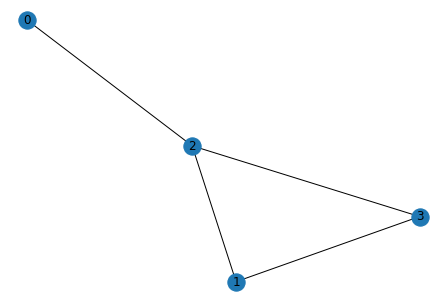

In [112]:
import networkx as nx
nx.draw(graph, with_labels=True)

In [82]:
graph = estimate_cpdag(skel_graph=graph, sep_set=sep_set)

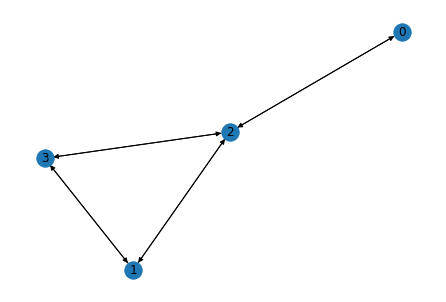

In [83]:
import networkx as nx
nx.draw(graph, with_labels=True)

In [55]:
from pcalg import estimate_cpdag
from pcalg import estimate_skeleton
from gsq.ci_tests import ci_test_bin, ci_test_dis
from gsq.gsq_testdata import bin_data, dis_data
import numpy as np
a=np.array(dis_data).reshape((10000, 5))
np.amax(a, axis=0)+1

array([3, 2, 3, 4, 2])

In [60]:
np.unique(np.array(bin_data))

array([0, 1])

In [30]:
data_matrix = np.array(bin_data).reshape((5000, 5))
(graph, sep_set) = estimate_skeleton(indep_test_func=ci_test_dis,
                                         data_matrix=data_matrix,
                                         alpha=0.01)

In [32]:
data_matrix.dtype

dtype('int64')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-q5em2nx9 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


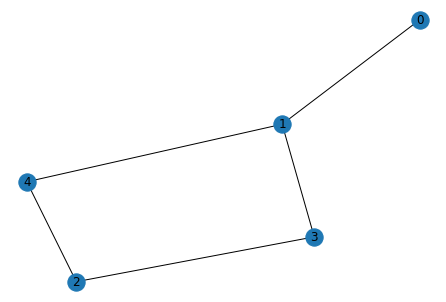

In [18]:
import networkx as nx
nx.draw(graph, with_labels=True)